# Bagging for data valuation

This notebook introduces the Data-OOB method, an implementation based on a publication from Kwon and Zou "[Data-OOB: Out-of-bag Estimate as a Simple and Efficient Data Value](https://proceedings.mlr.press/v202/kwon23e.html)" ICML 2023 , using pyDVL.


The objective of this paper is mainly to overcome the computational bottleneck of shapley-based data valuation methods that require to fit a significant number of models to accurately estimate marginal contributions.
The algorithms computes data values from out of bag estimates using a bagging model.

The value can be interpreted as a partition of the OOB estimate, which is originally introduced to estimate the prediction error. This OOB estimate is given as:

$$
\sum_{i=1}^n\frac{\sum_{b=1}^{B}\mathbb{1}(w_{bi}=0)T(y_i, \hat{f}_b(x_i))}{\sum_{b=1}^{B}
\mathbb{1}
(w_{bi}=0)}
$$


## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate (including most plotting code) has been omitted for convenience.

</div>

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import numpy as np

from pydvl.value import compute_data_oob
from pydvl.utils import Dataset, Utility, Scorer
from pydvl.reporting.scores import compute_removal_score
from pydvl.reporting.plots import shaded_mean_std

from pydvl.value.result import ValuationResult

In [2]:

from pydvl.value.result import ValuationResult
import seaborn as sns
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor# train an ECOD detector
from pyod.models.ecod import ECOD

In [3]:
from pydvl.reporting.plots import plot_best_worst, compute_best_worst_scores, plot_methods_linreg


In [4]:
def func(utility, method_name):
    if method_name == "Random":
            values = ValuationResult.from_random(size=len(utility.data))
    elif method_name == "IsolationForest":
        model = IsolationForest()
        model.fit(utility.data.x_train)
        values = ValuationResult(values = model.score_samples(utility.data.x_train))
    elif method_name == "LocalOutlierFactor":
        model = LocalOutlierFactor(novelty=True).fit(utility.data.x_train)
        values = ValuationResult(values = model.score_samples(utility.data.x_train))
    elif method_name == "OneClassSVM":
        model = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1).fit(utility.data.x_train, utility.data.y_train)
        values = ValuationResult(values = model.score_samples(utility.data.x_train))
    elif method_name == "EllipticEnvelope":
        model = EllipticEnvelope(random_state=0).fit(utility.data.x_train)
        values = ValuationResult(values = model.score_samples(utility.data.x_train))
    elif method_name == "oob":
        values = compute_data_oob(utility, n_est=20, max_samples=0.80)
    elif method_name == "EOCD":       
        clf = ECOD()
        clf.fit(utility.data.x_train)
        values = ValuationResult(values = clf.decision_scores_ )
         
    return values

methods =  ["Random","IsolationForest",
                            "LocalOutlierFactor","OneClassSVM", "EllipticEnvelope","oob","EOCD"]
kwargs_list = [{"method_name":m} for m in methods]

# Iris Dataset

In [5]:
import pandas as pd
from sklearn.datasets import load_iris

data = Dataset.from_sklearn(load_iris())

In [6]:
model = DecisionTreeClassifier()

utility = Utility(model, data, Scorer("accuracy", default=0.0))

Text(0.5, 1.0, 'ECOD')

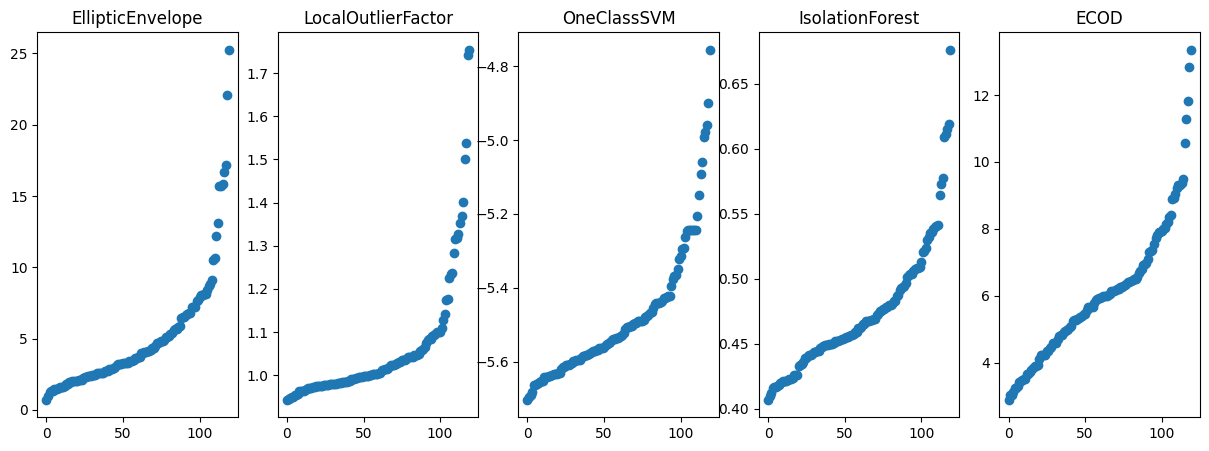

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=[15,5])
for i, (model, name) in enumerate(zip([EllipticEnvelope(random_state=0), LocalOutlierFactor(novelty=True),
                svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1), IsolationForest()], ["EllipticEnvelope", 
"LocalOutlierFactor",
"OneClassSVM",
"IsolationForest"])):#sklearn
    model.fit(utility.data.x_train)
    vals = -model.score_samples(utility.data.x_train)
    ax[i].scatter(np.arange(len(vals)), sorted(vals))
    ax[i].set_title(name)
    #vals = Normalizer().transform([vals])[0]
    #ax[i//2,i%2].scatter(np.arange(len(vals)), sorted(vals))
    #ax[1,i].scatter(np.arange(len(vals)), sorted(vals))
    

clf = ECOD()
clf.fit(utility.data.x_train)
# get outlier scores
y_train_scores = clf.decision_scores_  # raw outlier scores on the train data
#vals = clf.decision_function(utility.data.x_test)  # predict raw outlier scores on test
ax[-1].scatter(np.arange(len(y_train_scores)), sorted(y_train_scores))
ax[-1].set_title("ECOD")

## DecisionTreeClassifier

In [8]:
model_eval = DecisionTreeClassifier(max_depth=8)
#model_eval = DecisionTreeClassifier(max_depth=8)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, 
                                                        removal_percentages, n_iter, func, f_name="", kwargs_list=kwargs_list, return_values=True)

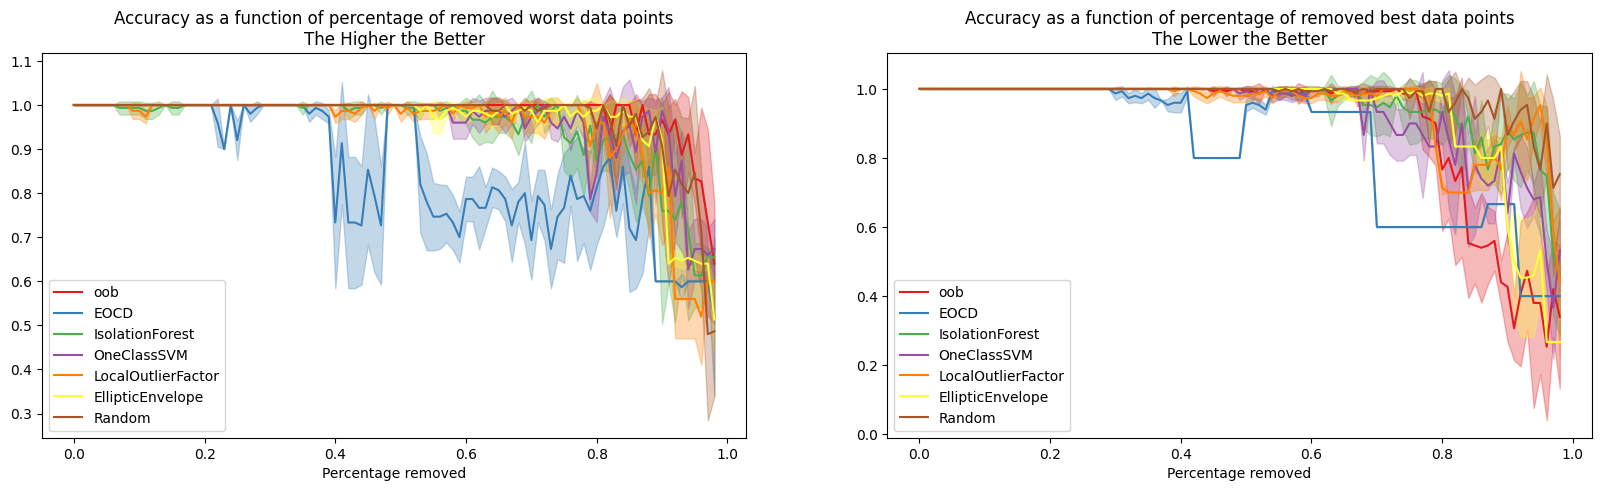

In [9]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="Set1")

In [10]:
from pydvl.reporting.plots import plot_best_worst_class_imbalance

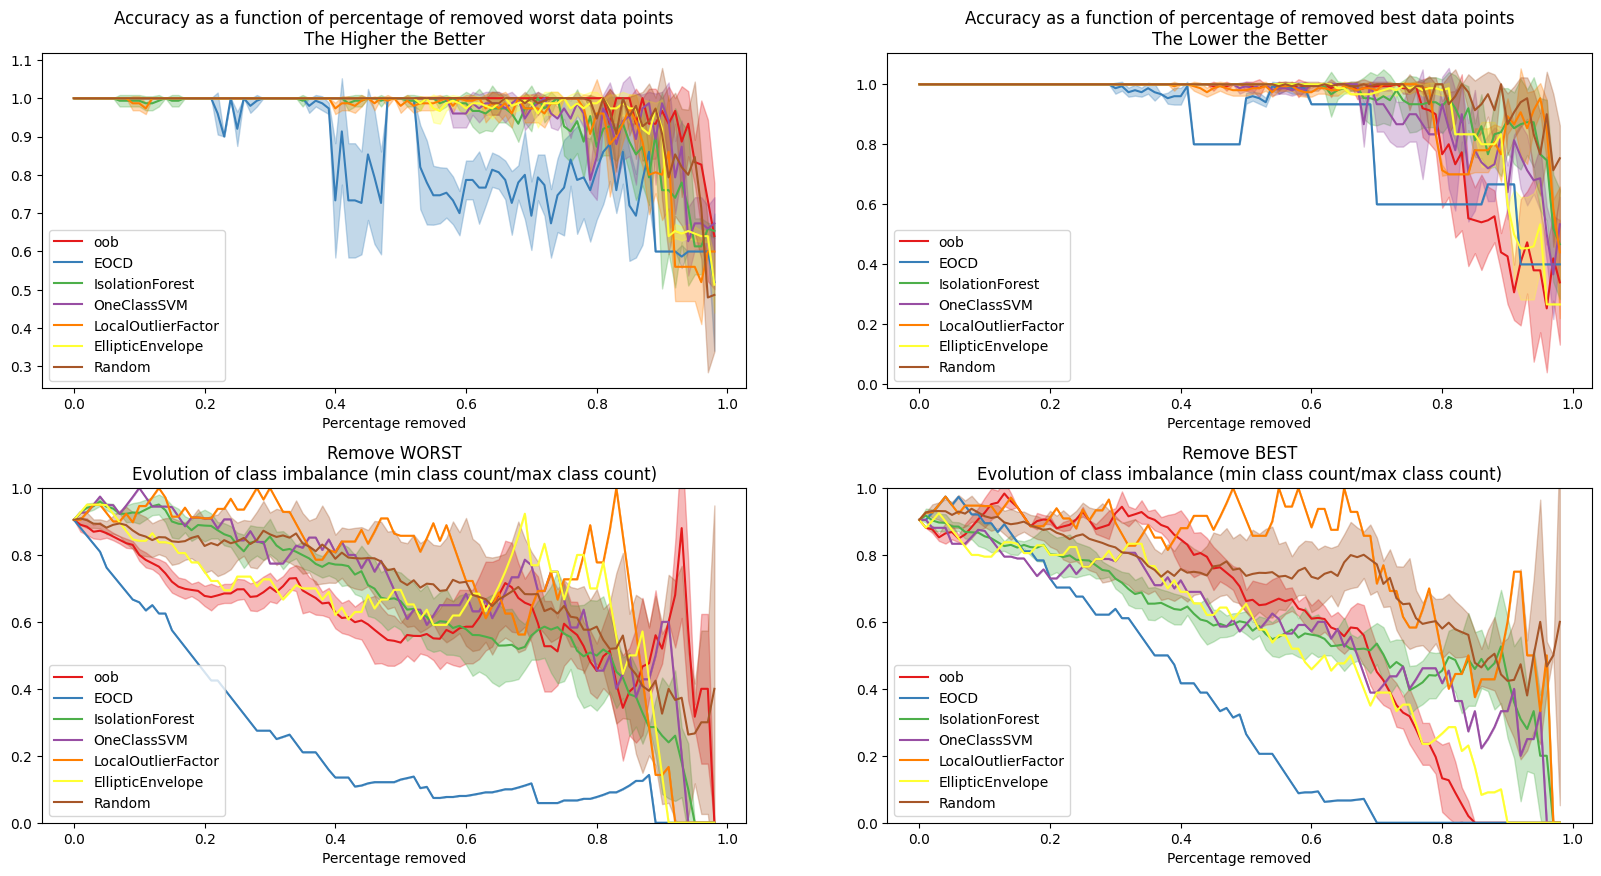

In [11]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="Set1")

In [12]:
from pydvl.reporting.plots import plot_methods_linreg

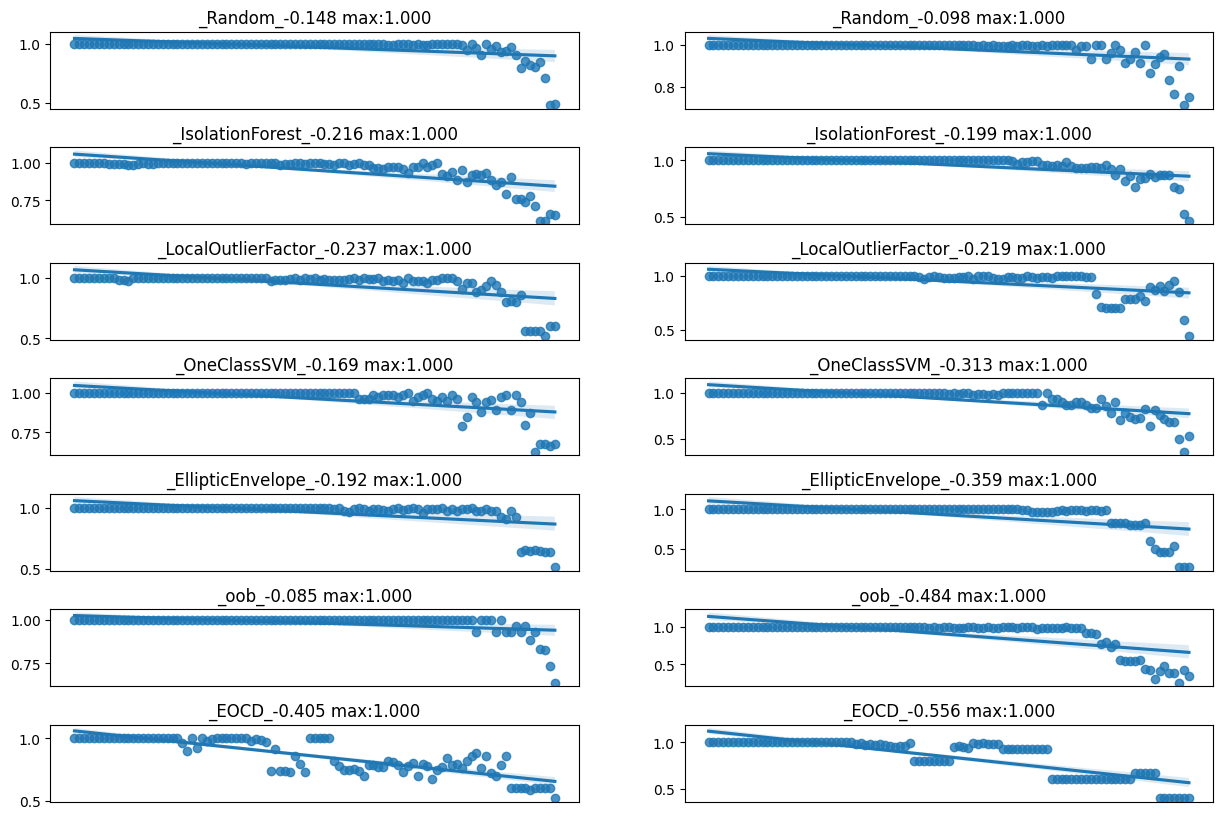

In [13]:
plot_methods_linreg(best_scores_df, worst_scores_df)

## LGBM

In [14]:
from lightgbm import LGBMClassifier

In [15]:

model_eval = LGBMClassifier(verbose=-1)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, 
                                                        removal_percentages, n_iter, func, f_name="", kwargs_list=kwargs_list, return_values=True)

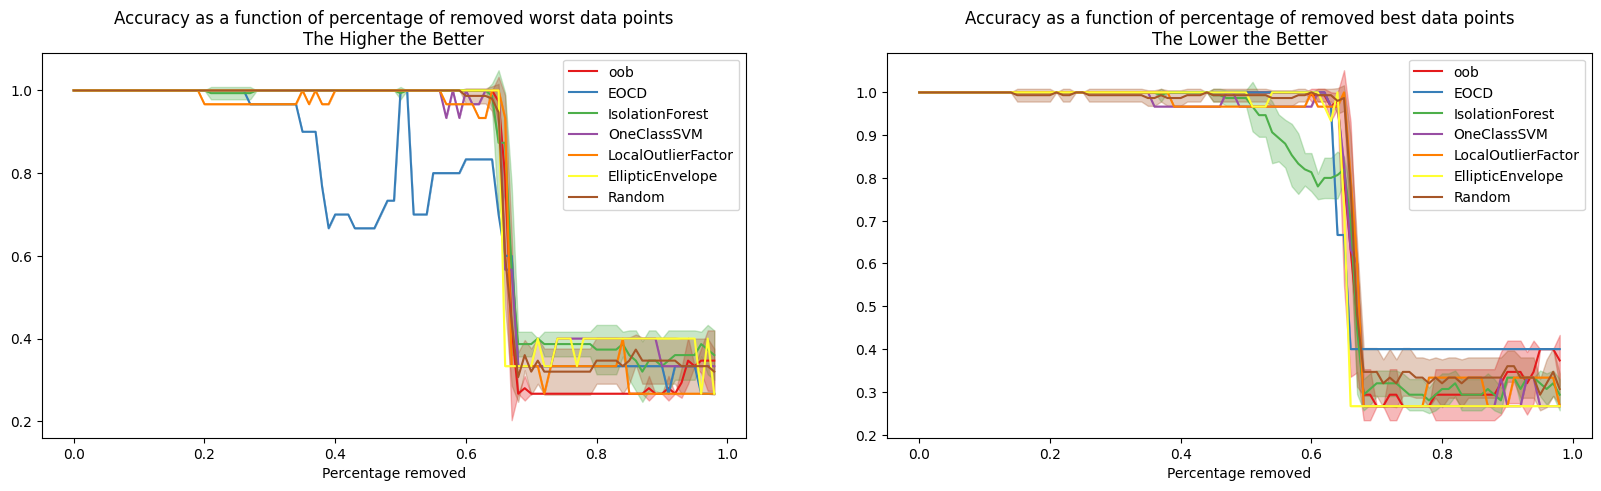

In [16]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="Set1")

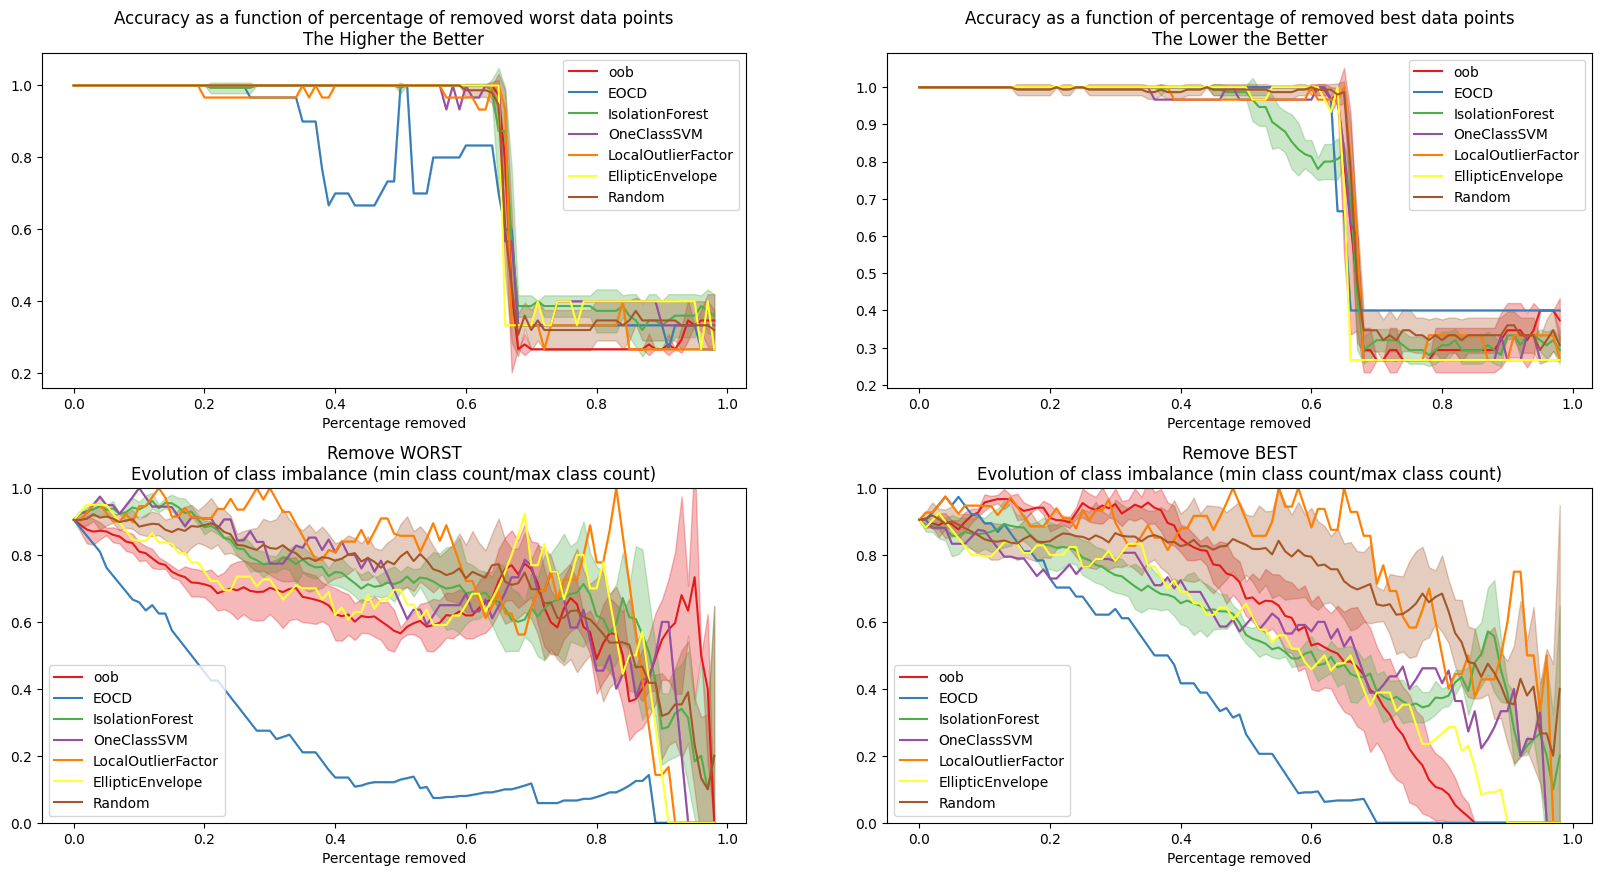

In [17]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="Set1")

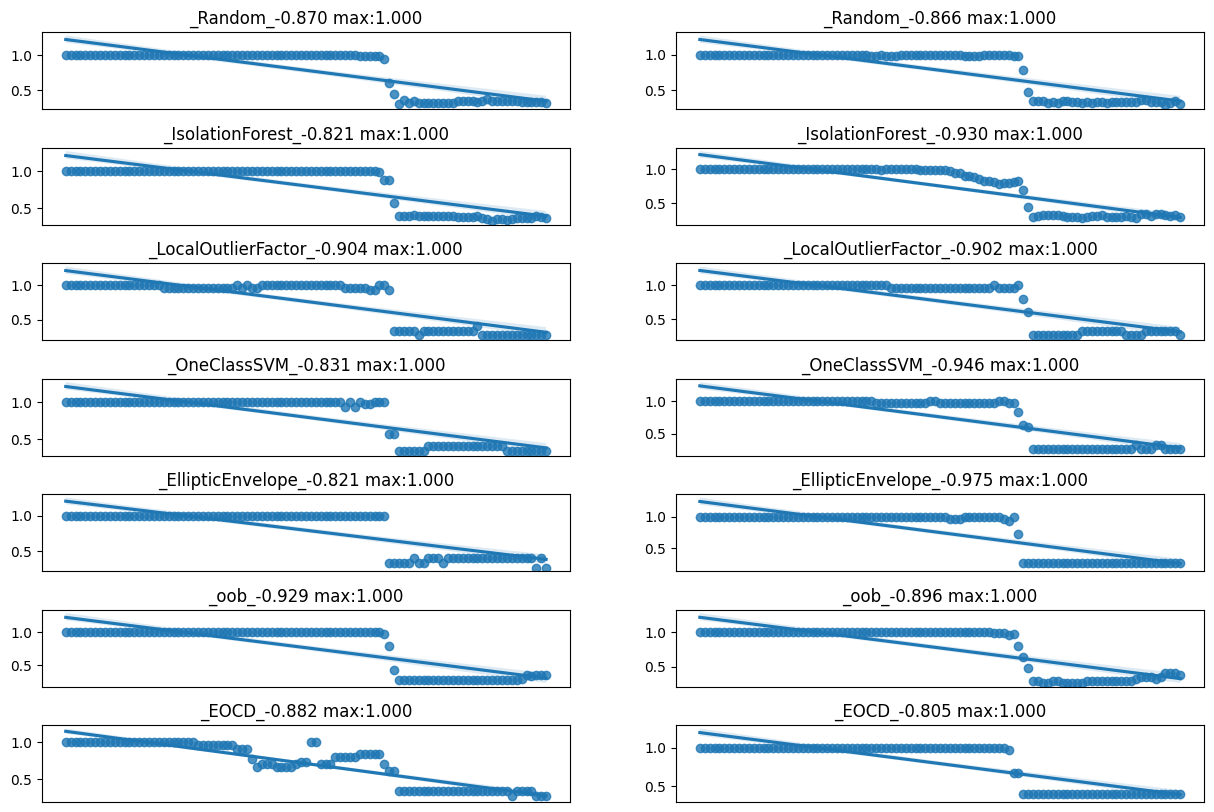

In [18]:
plot_methods_linreg(best_scores_df, worst_scores_df)

In [19]:
import pandas as pd
from sklearn.datasets import load_iris

data = Dataset.from_sklearn(load_iris())

In [20]:
model = DecisionTreeClassifier()

utility = Utility(model, data, Scorer("accuracy", default=0.0))

Text(0.5, 1.0, 'ECOD')

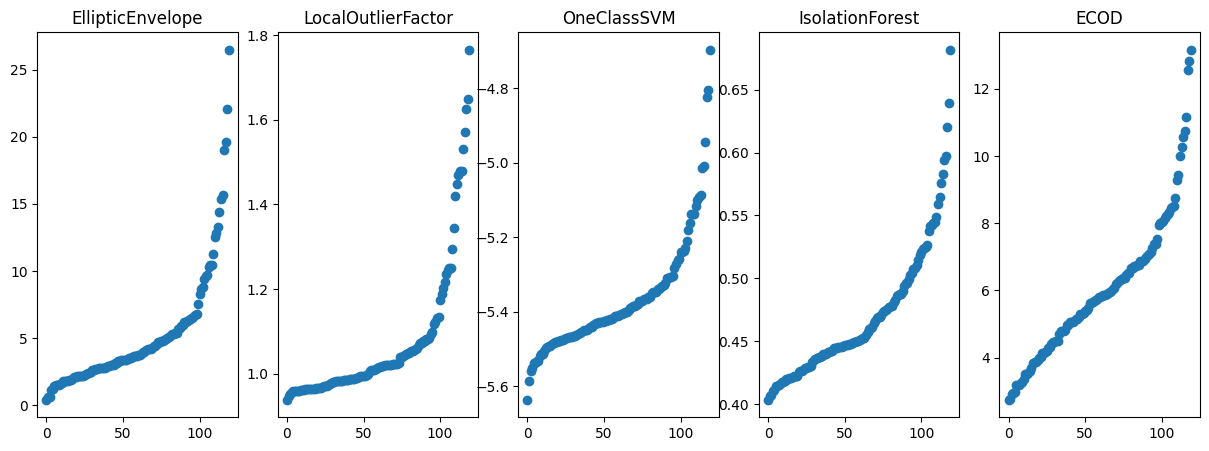

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=[15,5])
for i, (model, name) in enumerate(zip([EllipticEnvelope(random_state=0), LocalOutlierFactor(novelty=True),
                svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1), IsolationForest()], ["EllipticEnvelope", 
"LocalOutlierFactor",
"OneClassSVM",
"IsolationForest"])):#sklearn
    model.fit(utility.data.x_train)
    vals = -model.score_samples(utility.data.x_train)
    ax[i].scatter(np.arange(len(vals)), sorted(vals))
    ax[i].set_title(name)
    
    #vals = Normalizer().transform([vals])[0]
    #ax[i//2,i%2].scatter(np.arange(len(vals)), sorted(vals))
    #ax[1,i].scatter(np.arange(len(vals)), sorted(vals))
    

clf = ECOD()
clf.fit(utility.data.x_train)
# get outlier scores
y_train_scores = clf.decision_scores_  # raw outlier scores on the train data
#vals = clf.decision_function(utility.data.x_test)  # predict raw outlier scores on test
ax[-1].scatter(np.arange(len(y_train_scores)), sorted(y_train_scores))
ax[-1].set_title("ECOD")

# Diabetes DATASET

In [22]:
import pandas as pd
from sklearn.datasets import load_diabetes, load_wine

data = Dataset.from_sklearn(load_wine())

In [23]:
model = DecisionTreeClassifier()

utility = Utility(model, data, Scorer("accuracy", default=0.0))

## DecisionTreeClassifier

In [24]:

model_eval = DecisionTreeClassifier(max_depth=8)
#model_eval = DecisionTreeClassifier(max_depth=8)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, 
                                                        removal_percentages, n_iter, func, f_name="", kwargs_list=kwargs_list, return_values=True)

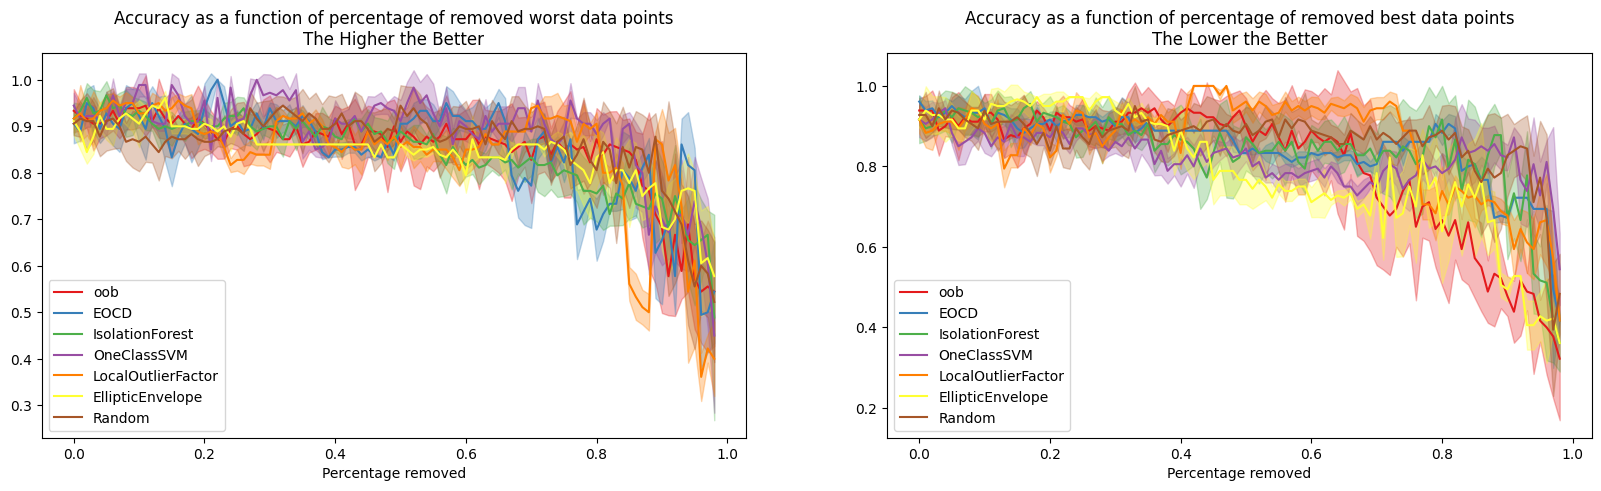

In [25]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="Set1")

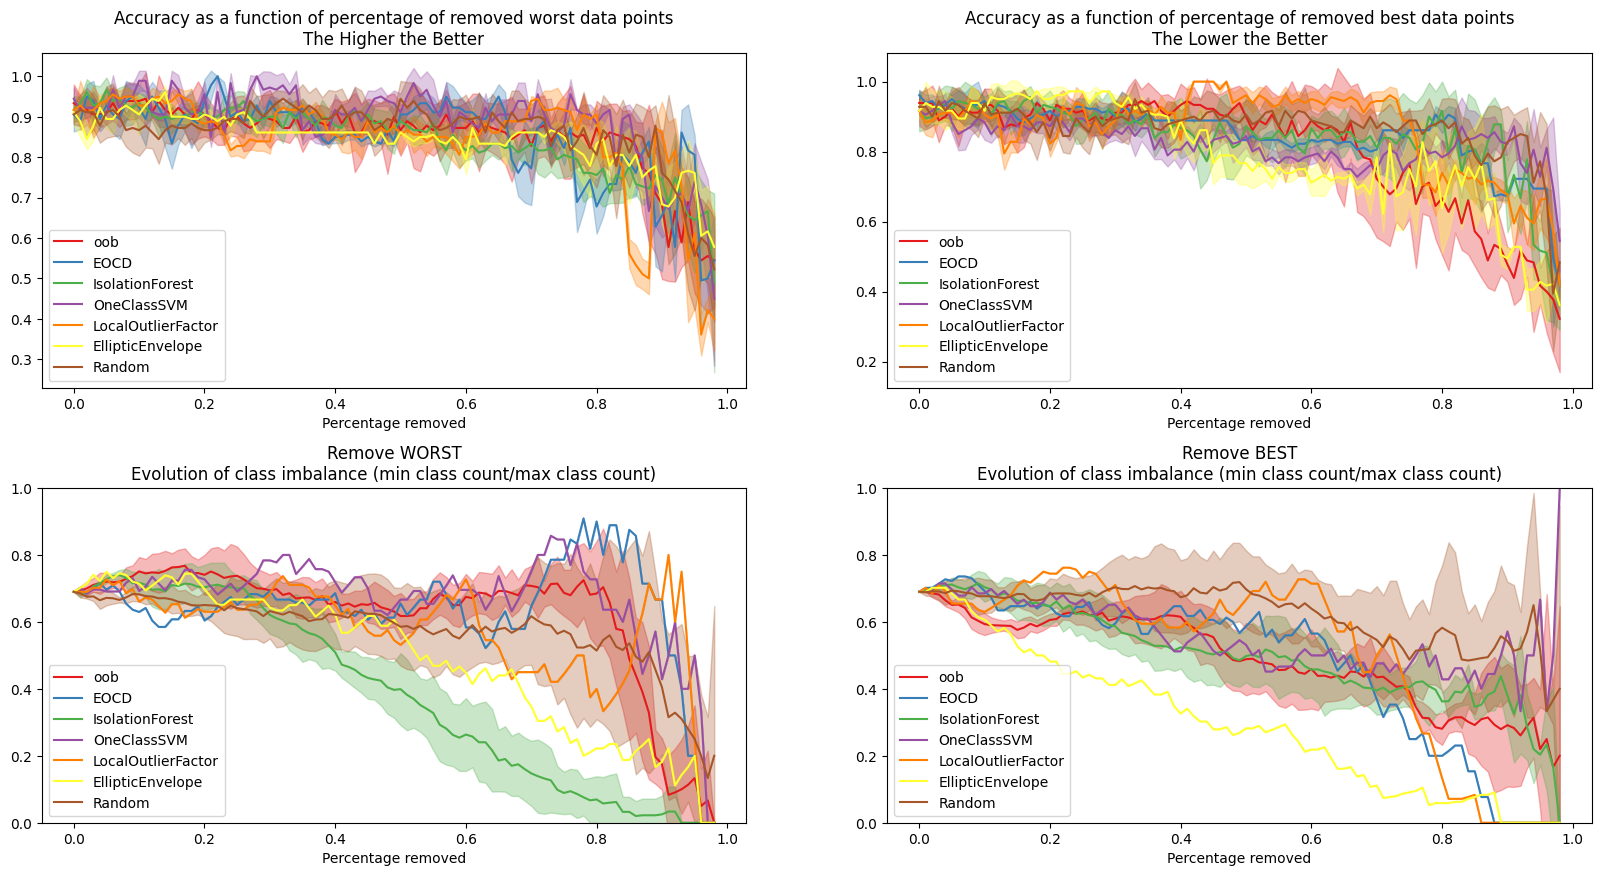

In [26]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="Set1")

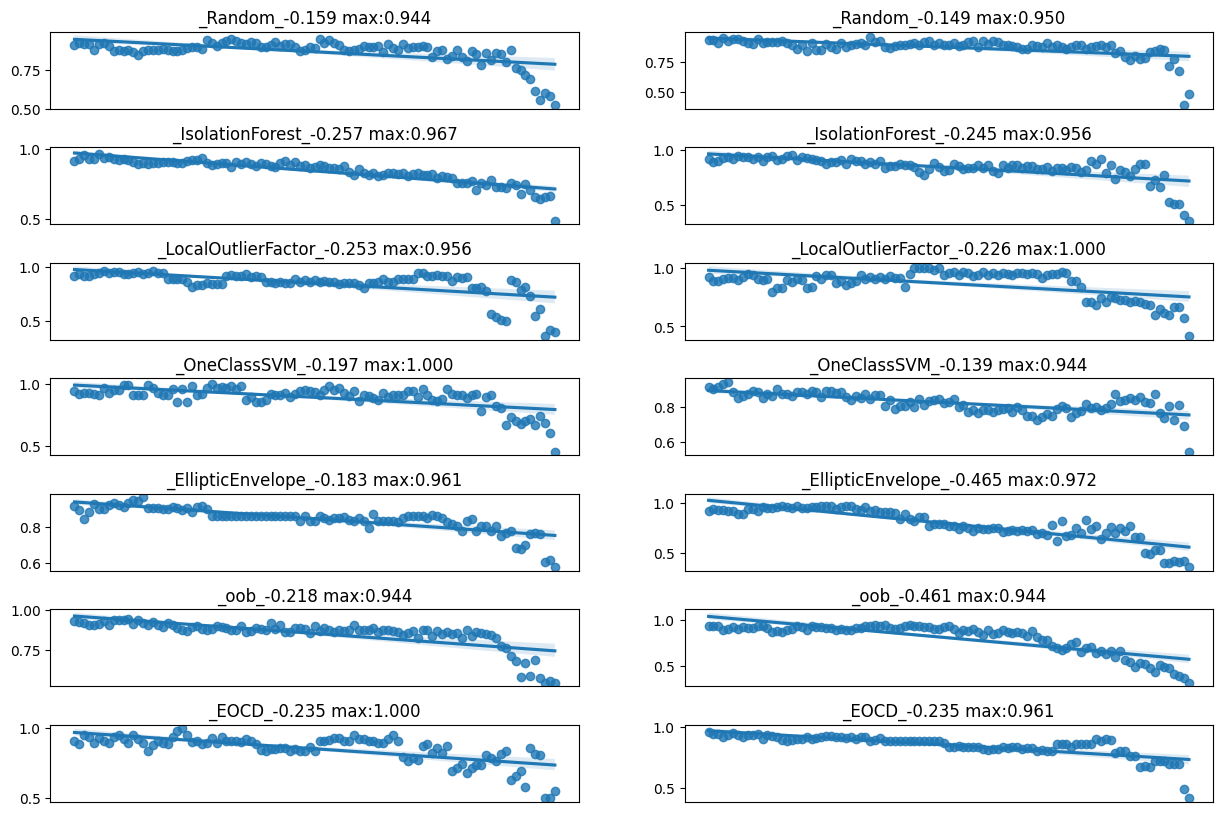

In [27]:
plot_methods_linreg(best_scores_df, worst_scores_df)

## LGBM

In [28]:
from lightgbm import LGBMClassifier

In [29]:

model_eval = LGBMClassifier(verbose=-1)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.02)
best_scores_df, worst_scores_df, all_values = compute_best_worst_scores(utility, utility_eval, 
                                                        removal_percentages, n_iter, func, f_name="", kwargs_list=kwargs_list, return_values=True)

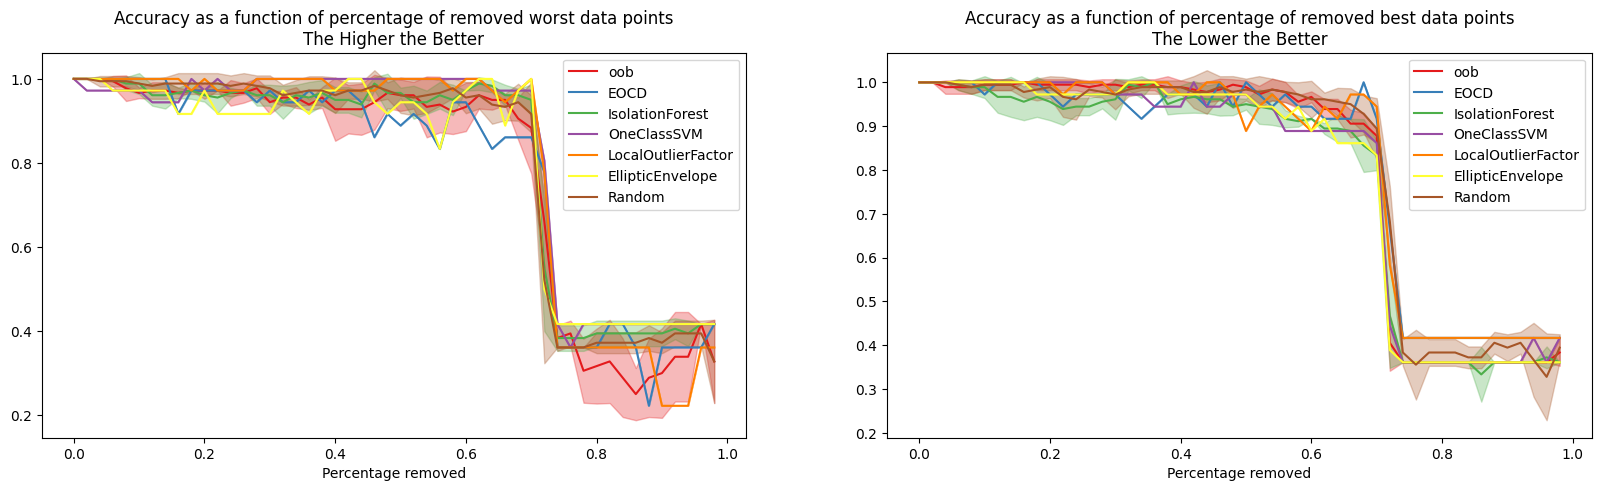

In [30]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="Set1")

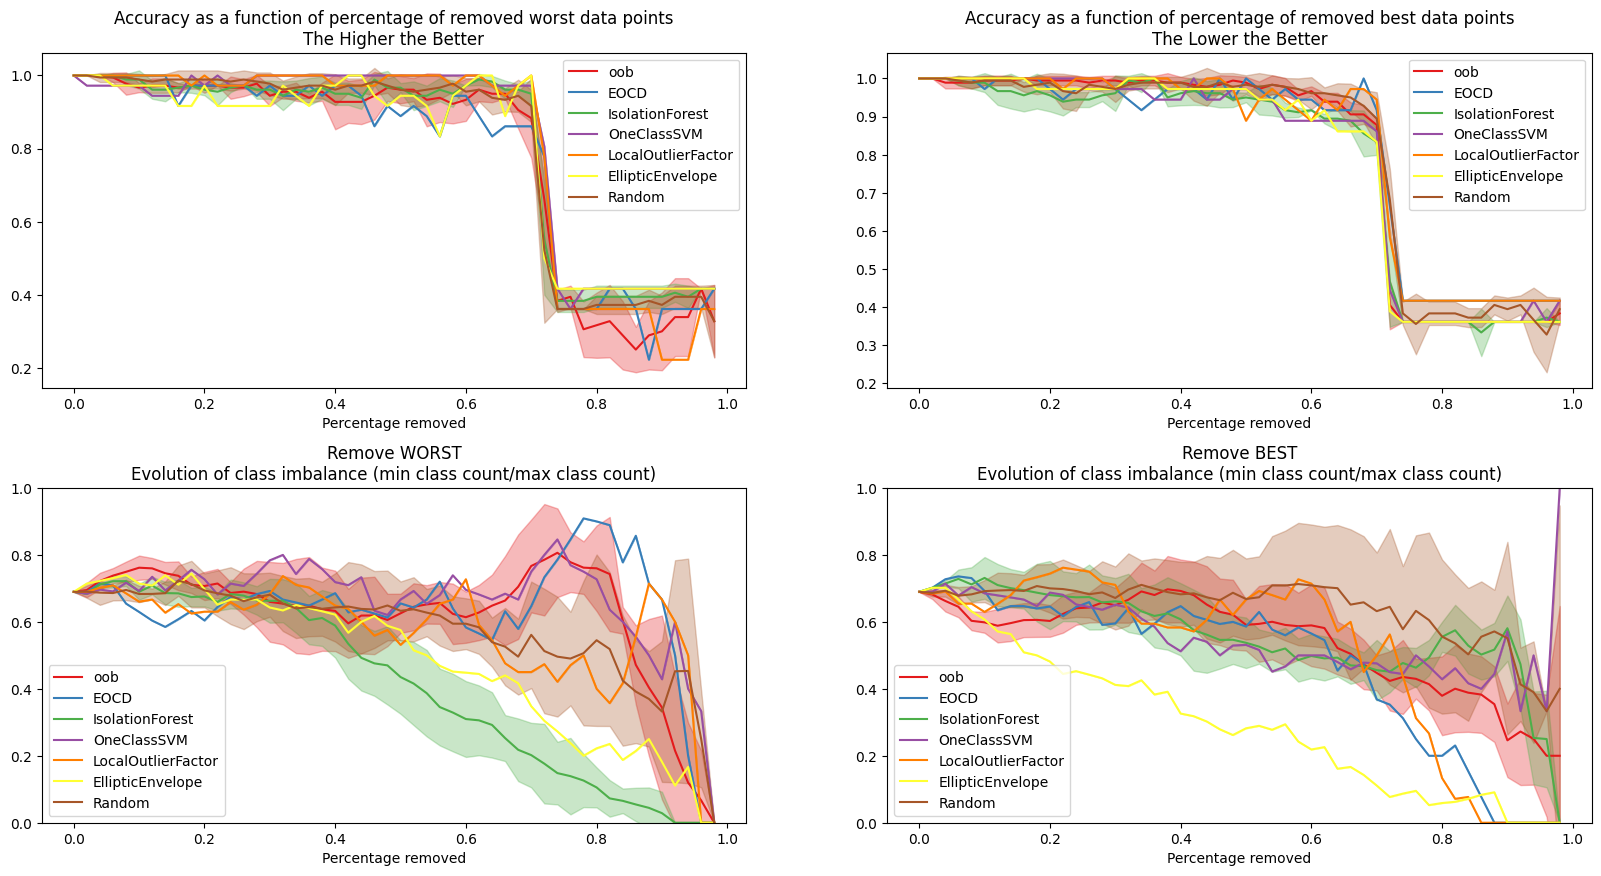

In [31]:
plot_best_worst_class_imbalance(best_scores_df, worst_scores_df, all_values, utility_eval, palette_name="Set1")

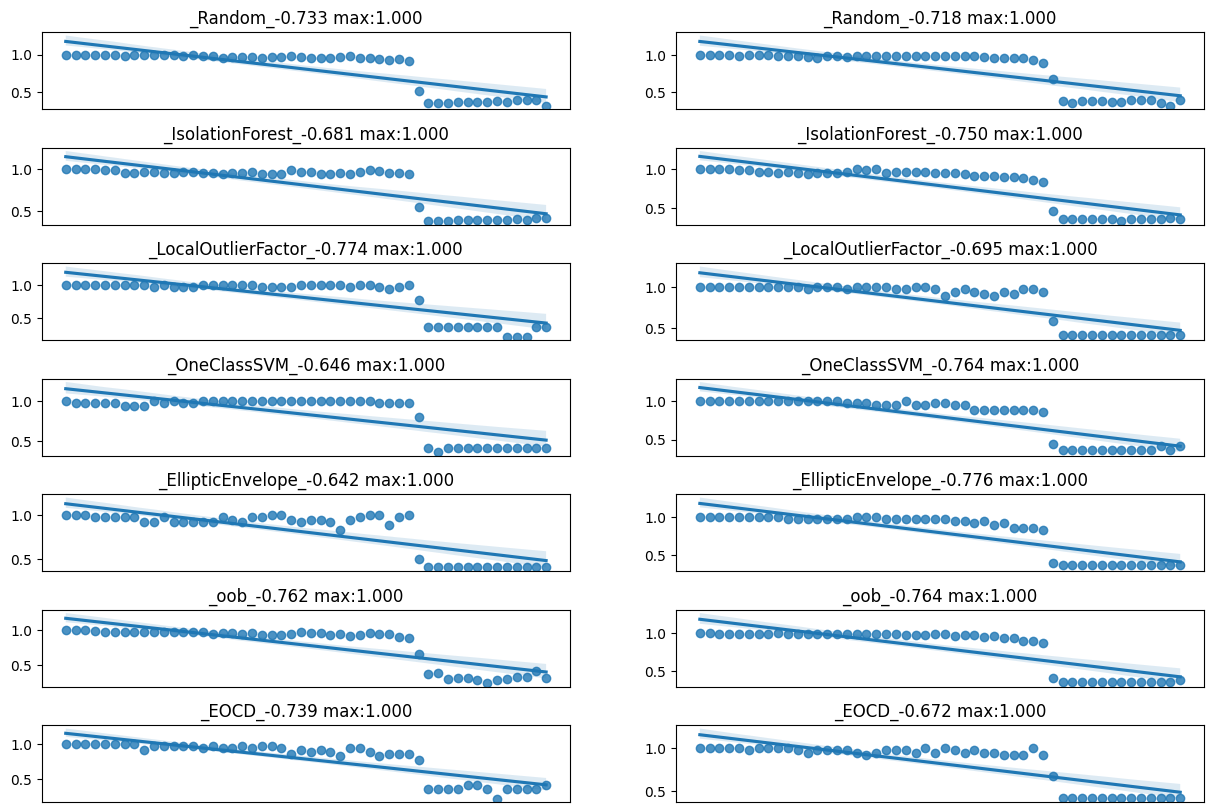

In [32]:
plot_methods_linreg(best_scores_df, worst_scores_df)

# Adult Dataset

In [33]:
import pandas as pd

# Specify the URL of the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Specify the column names
column_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]

# Specify the data types for each column
data_types = {
    "age": int,
    "workclass": "category",
    "fnlwgt": int,
    "education": "category",
    "education-num": int,
    "marital-status": "category",
    "occupation": "category",
    "relationship": "category",
    "race": "category",
    "sex": "category",
    "capital-gain": int,
    "capital-loss": int,
    "hours-per-week": int,
    "native-country": "category",
    "income": "category",
}

# Load the dataset into a pandas DataFrame
data_adult = pd.read_csv(
    url,
    names=column_names,
    sep=",\s*",
    engine="python",
    na_values="?",
    dtype=data_types,
    nrows=10000,
)

# Drop categorical columns
data_adult = data_adult.drop(
    columns=[
        "workclass",
        "education",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "native-country",
    ]
)


# Display the first few rows of the dataframe
print(data_adult.head())

   age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
0   39   77516             13          2174             0              40   
1   50   83311             13             0             0              13   
2   38  215646              9             0             0              40   
3   53  234721              7             0             0              40   
4   28  338409             13             0             0              40   

  income  
0  <=50K  
1  <=50K  
2  <=50K  
3  <=50K  
4  <=50K  


In [34]:
data = Dataset.from_arrays(
    X=data_adult.drop(columns=["income"]).values,
    y=data_adult.loc[:, "income"].cat.codes.values,
)

model = KNeighborsClassifier(n_neighbors=5)

utility = Utility(model, data, Scorer("accuracy", default=0.0))

Text(0.5, 1.0, 'ECOD')

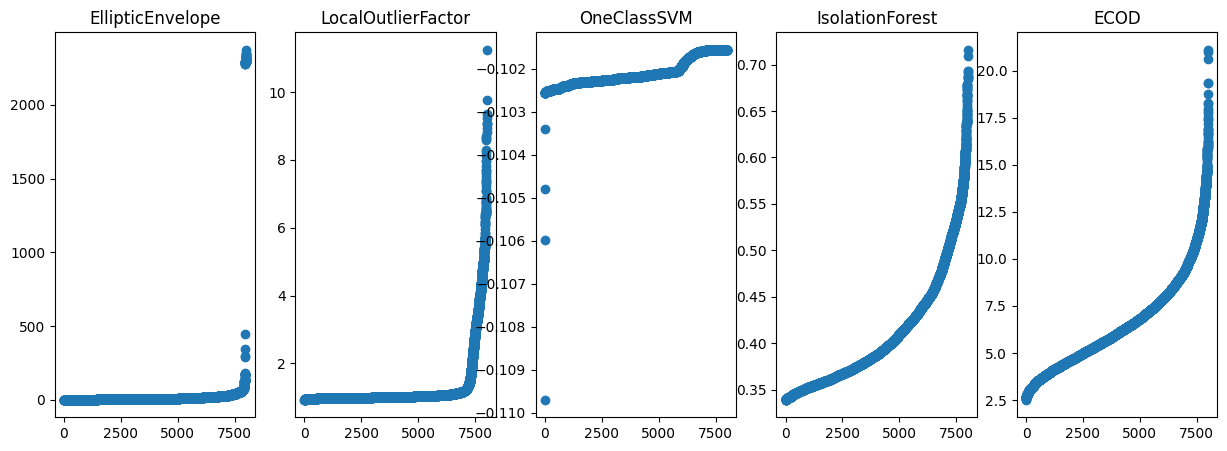

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=[15,5])
for i, (model, name) in enumerate(zip([EllipticEnvelope(random_state=0), LocalOutlierFactor(novelty=True),
                svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1), IsolationForest()], ["EllipticEnvelope", 
"LocalOutlierFactor",
"OneClassSVM",
"IsolationForest"])):#sklearn
    model.fit(utility.data.x_train)
    vals = -model.score_samples(utility.data.x_train)
    ax[i].scatter(np.arange(len(vals)), sorted(vals))
    ax[i].set_title(name)
    #vals = Normalizer().transform([vals])[0]
    #ax[i//2,i%2].scatter(np.arange(len(vals)), sorted(vals))
    #ax[1,i].scatter(np.arange(len(vals)), sorted(vals))
    

clf = ECOD()
clf.fit(utility.data.x_train)
# get outlier scores
y_train_scores = clf.decision_scores_  # raw outlier scores on the train data
#vals = clf.decision_function(utility.data.x_test)  # predict raw outlier scores on test
ax[-1].scatter(np.arange(len(y_train_scores)), sorted(y_train_scores))
ax[-1].set_title("ECOD")

## DecisionTreeClassifier

In [36]:

model_eval = DecisionTreeClassifier(max_depth=8)
#model_eval = DecisionTreeClassifier(max_depth=8)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df = compute_best_worst_scores(utility, utility_eval,
                                                    removal_percentages, n_iter, func,f_name="", kwargs_list=kwargs_list)

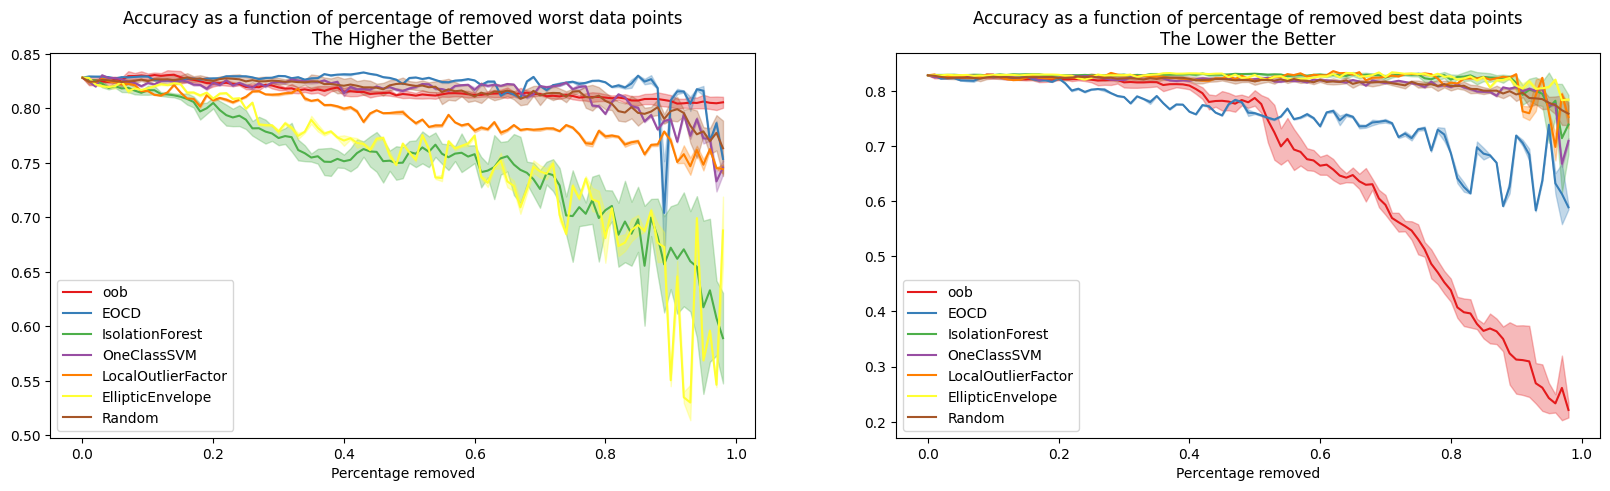

In [37]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="Set1")

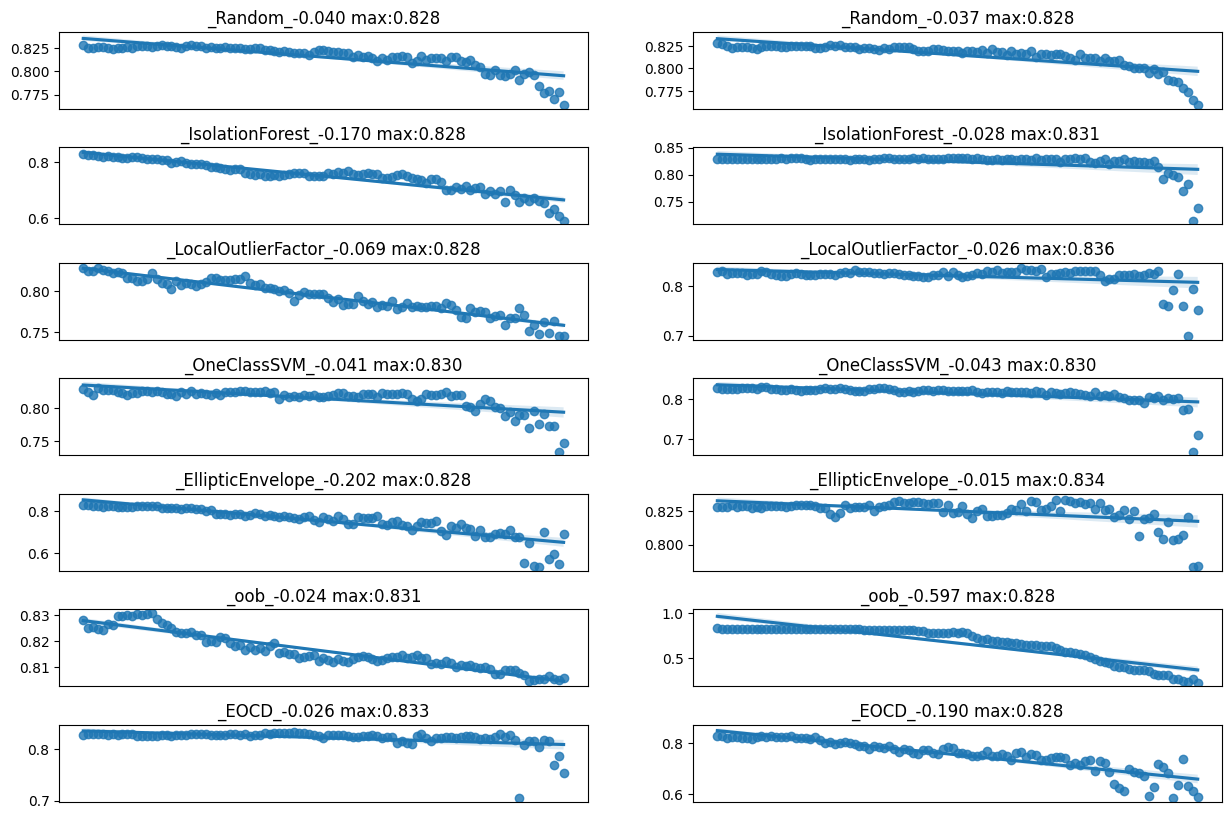

In [38]:
plot_methods_linreg(best_scores_df, worst_scores_df)

## LGBM

In [39]:
from lightgbm import LGBMClassifier

In [40]:

model_eval = LGBMClassifier(verbose=-1)
utility_eval = Utility(model_eval, data, Scorer("accuracy", default=0.0))
n_iter = 5
removal_percentages = np.arange(0, 0.99, 0.01)
best_scores_df, worst_scores_df = compute_best_worst_scores(utility, utility_eval,
                                                    removal_percentages, n_iter, func,f_name="", kwargs_list=kwargs_list)

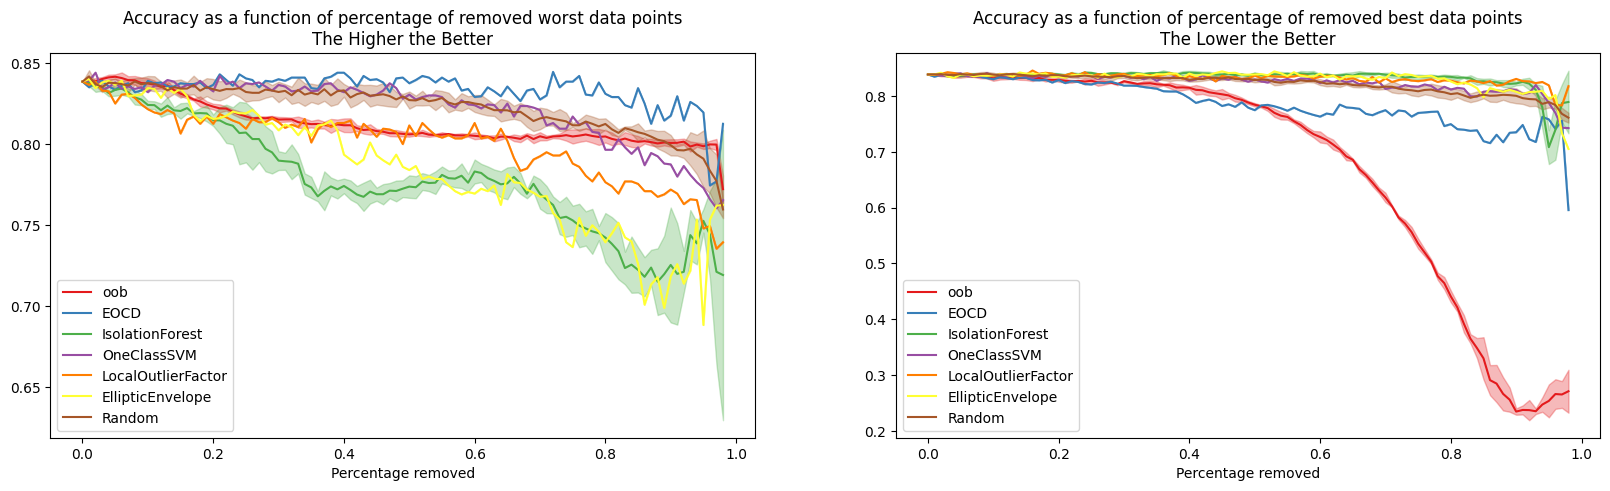

In [41]:
plot_best_worst(best_scores_df, worst_scores_df, palette_name="Set1")

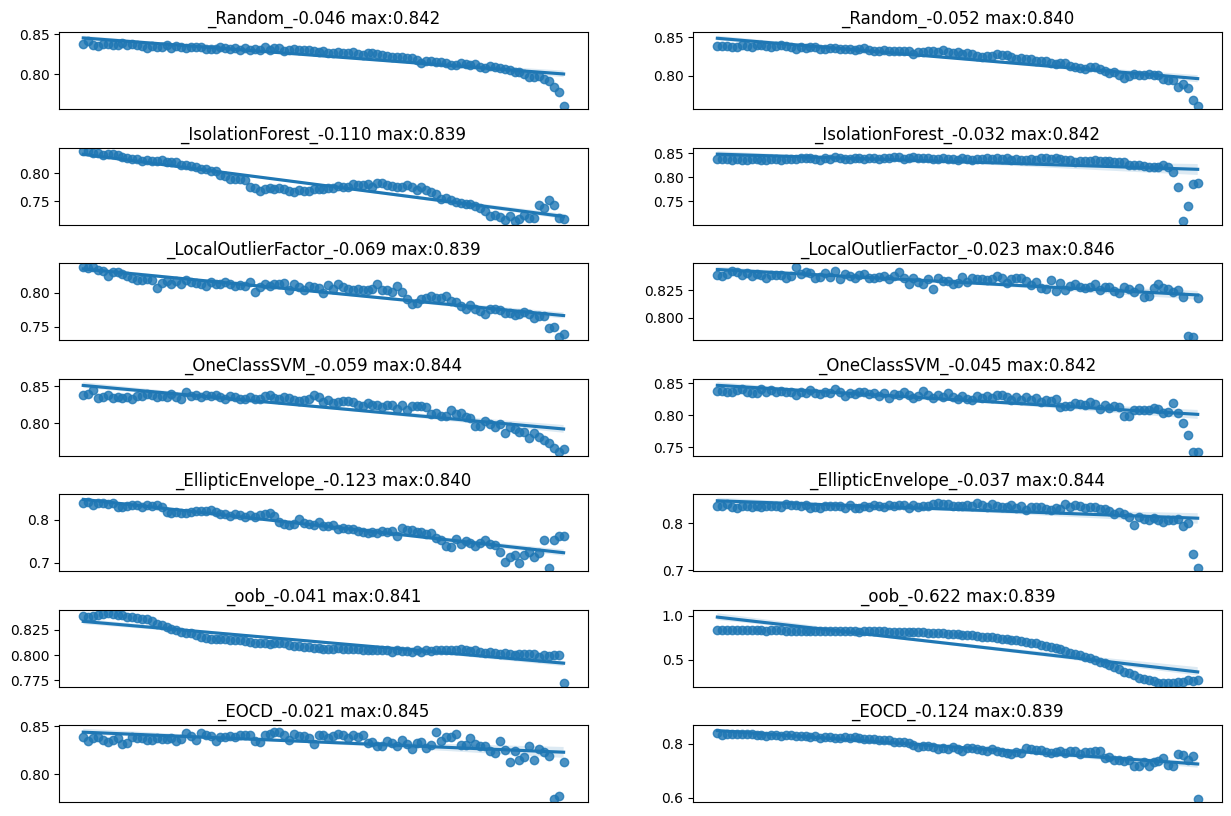

In [42]:
plot_methods_linreg(best_scores_df, worst_scores_df)